In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import torch
from torch.utils.data import DataLoader
import torchvision.models as models

sys.path.append(os.path.abspath("../activeweasul"))
from synthetic_data import SyntheticDataGenerator
from logisticregression import LogisticRegression
from discriminative_model import DiscriminativeModel
from label_model import LabelModel
from active_weasul import ActiveWeaSuLPipeline, set_seed
from experiment_utils import process_metric_dict, active_weasul_experiment, process_exp_dict, process_entropies, add_weak_supervision_baseline, active_learning_experiment
from visualrelation import VisualRelationDataset, VisualRelationClassifier
from vr_utils import load_vr_data
from lf_utils import apply_lfs, analyze_lfs
from datasets import CustomTensorDataset

# Figure 3: Artifical Data

## Generating data

We first create an artificial dataset with 2 classes of equal size. We generate a training set that contains 10.000 points and a test set that contains 3.000 points.

In [2]:
N = 10000
centroids = np.array([[0.1, 1.3], [-0.8, -0.5]])

p_z = 0.5

set_seed(932)
data = SyntheticDataGenerator(N, p_z, centroids)
df_train_3 = data.sample_dataset().create_df()
y_train_3 = df_train_3.y.values

In [3]:
N = 3000

set_seed(466)
data = SyntheticDataGenerator(N, p_z, centroids)
df_test_3 = data.sample_dataset().create_df()
y_test_3 = df_test_3.y.values

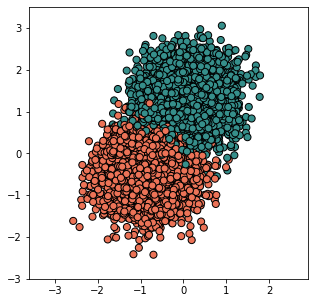

In [4]:
cmap = clr.LinearSegmentedColormap.from_list('', ['#368f8b',"#BBBBBB",'#ec7357'], N=200)

plt.figure(figsize=(5,5))
plt.scatter(x=df_train_3.x1, y=df_train_3.x2, c=y_train_3, s=50, edgecolor="black", cmap=cmap)
plt.xlim(-3.6,2.9)
plt.ylim(-3,3.5)
plt.show()

## Creating labelling functions

We apply 3 labelling functions to the dataset. Each labelling function assigns labels based on the value of one of the features. For example, the first labelling function assigns class 1 if $x_2$ is smaller than 0.4. We put them together in a label matrix that has a column for each labelling function.

In [5]:
df_train_3.loc[:, "wl1"] = (df_train_3.x2<0.4)*1
df_train_3.loc[:, "wl2"] = (df_train_3.x1<-0.3)*1
df_train_3.loc[:, "wl3"] = (df_train_3.x1<-1)*1

label_matrix_train_3 = df_train_3[["wl1", "wl2", "wl3"]].values

In [6]:
df_test_3.loc[:, "wl1"] = (df_test_3.x2<0.4)*1
df_test_3.loc[:, "wl2"] = (df_test_3.x1<-0.3)*1
df_test_3.loc[:, "wl3"] = (df_test_3.x1<-1)*1

label_matrix_test_3 = df_test_3[["wl1", "wl2", "wl3"]].values

## Running experiments

We set up experiments to compare the performance of Active WeaSuL to other approaches, such as only active learning. Each experiments runs 10 trials, where every trial starts from the same weak supervision setting at iteration 0 before going through the Active WeaSuL pipeline.

In [7]:
# Experiment settings
nr_trials = 10
al_it_3 = 30

# Active WeaSuL settings
starting_seed_346 = 36
penalty_strength_346 = 1

# Label model settings
class_balance_3 = np.array([1 - p_z, p_z])
cliques_346 = [[0], [1, 2]]

# Discriminative model settings
batch_size_3 = 256
discriminative_model_kwargs_3 = dict(input_dim=2,
                          output_dim=2,
                          lr=1e-1,
                          n_epochs=100)

In [8]:
# Plotting settings
font_size = 25
legend_size = 25
tick_size = 20
n_boot = 10000
linewidth = 4

In [9]:
# Collect all experiment parameters

# Common
exp_kwargs_3 = dict(nr_trials=nr_trials,
                  al_it=al_it_3,
                  y_train=y_train_3,
                  batch_size=batch_size_3,
                  y_test=y_test_3)

# Active WeaSuL
aw_exp_kwargs_3 = dict(label_matrix=label_matrix_train_3,
                  cliques=cliques_346,
                  class_balance=class_balance_3,
                  starting_seed=starting_seed_346,
                  penalty_strength=penalty_strength_346,
                  discriminative_model=LogisticRegression(**discriminative_model_kwargs_3, early_stopping=True, patience=5),
                  discr_model_frequency=1,
                  train_dataset = CustomTensorDataset(X=torch.Tensor(df_train_3.loc[:,["x1", "x2"]].values), Y=y_train_3),
                  test_dataset = CustomTensorDataset(X=torch.Tensor(df_test_3.loc[:,["x1", "x2"]].values), Y=y_test_3),
                  label_matrix_test=label_matrix_test_3)

### Active WeaSuL

In [10]:
np.random.seed(284)
aw_exp_kwargs_3["seeds"]= np.random.randint(0,1000,10)
metrics_maxkl_3, _ = active_weasul_experiment(**exp_kwargs_3, **aw_exp_kwargs_3, query_strategy="maxkl")

### Nashaat et al.

Now we run the experiment on our artificial dataset for our implementation of the approach by Nashaat et al.

In [11]:
np.random.seed(25)
aw_exp_kwargs_3["seeds"]= np.random.randint(0,1000,10)
metrics_nashaat_3, _ = active_weasul_experiment(**exp_kwargs_3, **aw_exp_kwargs_3, query_strategy="nashaat")

### Increase number of active learning iterations

Since the impact on performance across iterations is not clearly visible during the first 30 iterations for Nashaat et al., we run Active WeaSuL and the Nashaat et al. method for up to 1000 active learning iterations.

In [12]:
exp_kwargs_3["al_it"] = 1000
aw_exp_kwargs_3["discr_model_frequency"] = 50

In [13]:
# Active WeaSuL 1000 iterations
np.random.seed(284) 
aw_exp_kwargs_3["seeds"]= np.random.randint(0,1000,10)
metrics_maxkl_1000_3, _ = active_weasul_experiment(**exp_kwargs_3, **aw_exp_kwargs_3, query_strategy="maxkl")

In [14]:
# Nashaat 1000 iterations
np.random.seed(25)
aw_exp_kwargs_3["seeds"]= np.random.randint(0,1000,10)
metrics_nashaat_1000_3, _ = active_weasul_experiment(**exp_kwargs_3, **aw_exp_kwargs_3, query_strategy="nashaat")

In [15]:
exp_kwargs_3["al_it"] = al_it_3
aw_exp_kwargs_3["discr_model_frequency"] = 1

### Active learning

Next, we run active learning by itself.

In [16]:
set_seed(76)

# Active learning parameters
al_exp_kwargs_3 = dict(
    seeds = np.random.randint(0,1000,nr_trials),
    train_features = torch.Tensor(df_train_3.loc[:, ["x1","x2"]].values),
    test_features=df_test_3.loc[:, ["x1", "x2"]].values
)

In [17]:
metrics_activelearning_3 = active_learning_experiment(**exp_kwargs_3, **al_exp_kwargs_3)

### Process results

In [18]:
# Transform results into dataframes and merge

metric_dfs_3 = pd.concat([process_exp_dict(metrics_maxkl_3, "Active WeaSuL"),
                        process_exp_dict(metrics_nashaat_3, "Nashaat et al."),
                        process_exp_dict(metrics_activelearning_3, "Active learning by itself")]).reset_index(level=0).rename(columns={"level_0": "Run"})

# Add weak supervision baseline
metric_dfs_incl_ws_3 = add_weak_supervision_baseline(metric_dfs_3, al_it_3)

metric_dfs_1000_3 = pd.concat([process_exp_dict(metrics_maxkl_1000_3, "Active WeaSuL"),
                             process_exp_dict(metrics_nashaat_1000_3, "Nashaat et al.")]).reset_index(level=0).rename(columns={"level_0": "Run"})

In [19]:
# Filter to plot only accuracy metric and test set

metric_dfs_incl_ws_3 = metric_dfs_incl_ws_3[metric_dfs_incl_ws_3["Metric"] == "Accuracy"]
metric_dfs_incl_ws_3 = metric_dfs_incl_ws_3[metric_dfs_incl_ws_3["Set"] == "test"]
metric_dfs_incl_ws_3["Value"] = metric_dfs_incl_ws_3["Value"].fillna(0.5)

metric_dfs_1000_3 = metric_dfs_1000_3[metric_dfs_1000_3["Metric"] == "Accuracy"]
metric_dfs_1000_3 = metric_dfs_1000_3[metric_dfs_1000_3["Set"] == "test"]

## Figure 3

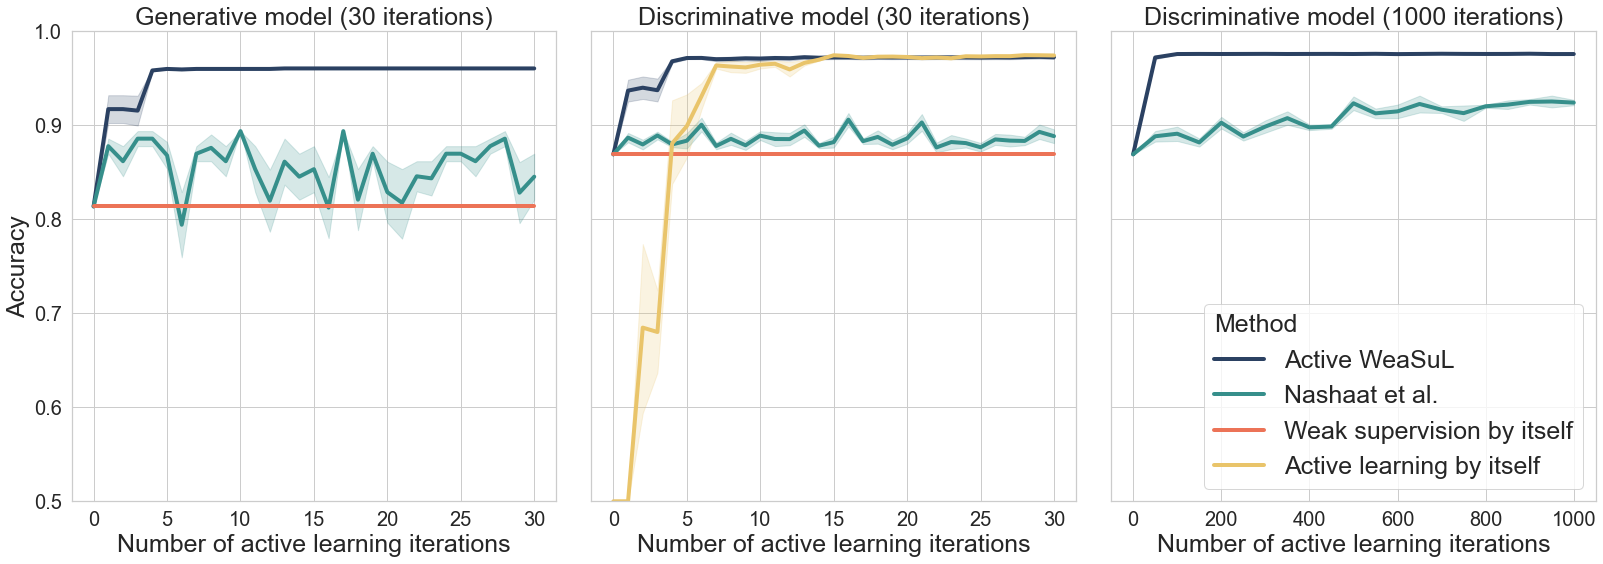

In [20]:
plotting_kwargs = dict(x="Number of labeled points", y="Value", hue="Approach",
                       ci=68, n_boot=n_boot, estimator="mean", linewidth=linewidth)

# Style
colors = ["#2b4162", "#368f8b", "#ec7357", "#e9c46a"]
sns.set(style="whitegrid", palette=sns.color_palette(colors))

fig, axes = plt.subplots(1,3, figsize=(22.5,8), sharey=True)

# First column
sns.lineplot(data=metric_dfs_incl_ws_3[metric_dfs_incl_ws_3["Model"] == "Generative"], legend=False, **plotting_kwargs,
            hue_order=["Active WeaSuL", "Nashaat et al.", "Weak supervision by itself"], ax=axes[0])
axes[0].set_title("Generative model (30 iterations)", size=font_size)

# Second column
sns.lineplot(data=metric_dfs_incl_ws_3[metric_dfs_incl_ws_3["Model"] == "Discriminative"], **plotting_kwargs,
            hue_order=["Active WeaSuL", "Nashaat et al.", "Weak supervision by itself", "Active learning by itself"], ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_title("Discriminative model (30 iterations)", fontsize=font_size)

# Third column
sns.lineplot(data=metric_dfs_1000_3[metric_dfs_1000_3["Model"] == "Discriminative"],
                  hue_order=["Active WeaSuL", "Nashaat et al."], **plotting_kwargs)
axes[2].set_title("Discriminative model (1000 iterations)", fontsize=font_size)

# Legend
handles, labels = axes[1].get_legend_handles_labels()
[ha.set_linewidth(linewidth) for ha in handles]
leg = axes[2].legend(handles=handles, labels=labels, loc="lower right", title="Method", fontsize=legend_size, title_fontsize=legend_size)
leg._legend_box.align = "left"

# Axes
for i in range(3): 
    axes[i].tick_params(axis='both', which='major', labelsize=tick_size)
    axes[i].set_xlabel("Number of active learning iterations", fontsize=font_size)
axes[0].set_ylabel("Accuracy", fontsize=font_size)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

# Figure 4: Visual Relationship Detection

The weak supervision setup for the dataset in this section builds on https://github.com/snorkel-team/snorkel-tutorials/tree/master/visual_relation.

In [21]:
pretrained_model = models.resnet18(pretrained=True)
path_prefix_46 = "../data/VRD/"

## Loading and preparing data

We select a subset of meaningful predicates from the VRD dataset and label "sit on" versus other predicates.

In [22]:
semantic_predicates = ["carry", "cover", "fly", "look", "lying on", "park on", "sit on", "stand on", "ride"]
classify = ["sit on"]

df_train_46, df_test_46 = load_vr_data(classify=classify, include_predicates=semantic_predicates,
                                 path_prefix=path_prefix_46, drop_duplicates=True, validation=False)

y_train_46 = df_train_46.y.values
y_test_46 = df_test_46.y.values

We first extract features from the images and object categories, then save resulting embeddings for fast fine-tuning.

In [23]:
dataset_train = VisualRelationDataset(image_dir=path_prefix_46 + "/images/train_images", df=df_train_46, Y=y_train_46)
dl_train = DataLoader(dataset_train, shuffle=False, batch_size=256)

discriminative_model = VisualRelationClassifier(pretrained_model, lr=1e-3, n_epochs=3, data_path_prefix="../data/", soft_labels=False)

feature_tensor_train = torch.Tensor([])
for batch_features, batch_labels in dl_train:
    feature_tensor_train = torch.cat((feature_tensor_train, discriminative_model.extract_concat_features(batch_features).to("cpu")))

In [24]:
dataset_test = VisualRelationDataset(image_dir=path_prefix_46 + "images/test_images", df=df_test_46, Y=y_test_46)
dl_test = DataLoader(dataset_test, shuffle=False, batch_size=256)

feature_tensor_test = torch.Tensor([])
for batch_features, batch_labels in dl_test:
    feature_tensor_test = torch.cat((feature_tensor_test, discriminative_model.extract_concat_features(batch_features).to("cpu")))

## Creating labelling functions

We define three different labelling functions. The first classifies based on the subject and object categories in the image. The second is based on the distance between the object and the subject. The third is based on the relative sizes of the bounding boxes of the object and the subject.

In [25]:
SITON = 1
OTHER = 0

def lf_siton_object(x):
    if x.subject_category == "person":
        if x.object_category in ["bench", "chair", "floor", "horse", "grass", "table"]:
            return SITON
    return OTHER

def lf_dist(x):
    if np.linalg.norm(np.array(x.subject_bbox) - np.array(x.object_bbox)) >= 100:
        return OTHER
    return SITON

def area(bbox):
    return (bbox[1] - bbox[0]) * (bbox[3] - bbox[2])

def lf_area(x):
    if area(x.subject_bbox) / area(x.object_bbox) < 0.8:
        return SITON
    return OTHER

In [26]:
lfs = [lf_siton_object, lf_dist, lf_area]

label_matrix_train_46 = apply_lfs(df_train_46, lfs)
label_matrix_test_46 = apply_lfs(df_test_46, lfs)

## Running experiments

In [27]:
# Update some settings for this dataset

al_it_46 = 250

class_balance_46 = np.array([1-df_train_46.y.mean(), df_train_46.y.mean()])

discriminative_model_kwargs_46 = dict(lr=1e-3,n_epochs=100)
batch_size_456 = 20

In [28]:
# Collect all experiment parameters

# Common
exp_kwargs_46 = dict(nr_trials=nr_trials,
                  al_it=al_it_46,
                  y_train=y_train_46,
                  batch_size=batch_size_456,
                  y_test=y_test_46)

# Active WeaSuL
aw_exp_kwargs_46 = dict(label_matrix=label_matrix_train_46,
                     cliques=cliques_346,
                     class_balance=class_balance_46,
                     starting_seed=starting_seed_346,
                     penalty_strength=penalty_strength_346,
                     discriminative_model=VisualRelationClassifier(pretrained_model, **discriminative_model_kwargs_46, data_path_prefix="../data/", patience=5, early_stopping=True),
                     discr_model_frequency=1,
                     train_dataset = CustomTensorDataset(feature_tensor_train, torch.Tensor(y_train_46)),
                     test_dataset = CustomTensorDataset(feature_tensor_test, torch.Tensor(y_test_46)),
                     label_matrix_test=label_matrix_test_46)

### Active WeaSuL

In [29]:
np.random.seed(50)
aw_exp_kwargs_46["seeds"]= np.random.randint(0,1000,nr_trials)
metrics_maxkl_46, entropies_maxkl_46 = active_weasul_experiment(**exp_kwargs_46, **aw_exp_kwargs_46, query_strategy="maxkl")

### Nashaat et al.

In [30]:
np.random.seed(25)
aw_exp_kwargs_46["seeds"]= np.random.randint(0,1000,nr_trials)
metrics_nashaat_46, _ = active_weasul_experiment(**exp_kwargs_46, **aw_exp_kwargs_46, query_strategy="nashaat")

### Active learning

In [31]:
set_seed(76)

# Not using early stopping for active learning, so reduce the number of epochs
discriminative_model_kwargs_46["n_epochs"] = 2

# Active learning parameters
al_exp_kwargs_46 = dict(seeds = np.random.randint(0,1000,nr_trials),
                        input_model = VisualRelationClassifier(pretrained_model, **discriminative_model_kwargs_46, early_stopping=False, data_path_prefix="../data/", soft_labels=False),
                        train_features = feature_tensor_train,
                        test_features=feature_tensor_test)

discriminative_model_kwargs_46["n_epochs"] = 100

In [32]:
metrics_activelearning_46 = active_learning_experiment(**exp_kwargs_46, **al_exp_kwargs_46)

### Process results

In [33]:
# Transform results into dataframes and merge

metric_dfs_46 = pd.concat([process_exp_dict(metrics_maxkl_46, "Active WeaSuL"),
                        process_exp_dict(metrics_nashaat_46, "Nashaat et al."),
                        process_exp_dict(metrics_activelearning_46, "Active learning by itself")]).reset_index(level=0).rename(columns={"level_0": "Run"})

# Add weak supervision baseline
metric_dfs_incl_ws_46 = add_weak_supervision_baseline(metric_dfs_46, al_it_46)

In [34]:
# Filter to plot only F1 metric and test set

metric_dfs_incl_ws_46 = metric_dfs_incl_ws_46[metric_dfs_incl_ws_46["Metric"] == "F1"]
metric_dfs_incl_ws_46 = metric_dfs_incl_ws_46[metric_dfs_incl_ws_46["Set"] == "test"]
metric_dfs_incl_ws_46["Value"] = metric_dfs_incl_ws_46["Value"].fillna(0)

## Figure 4B

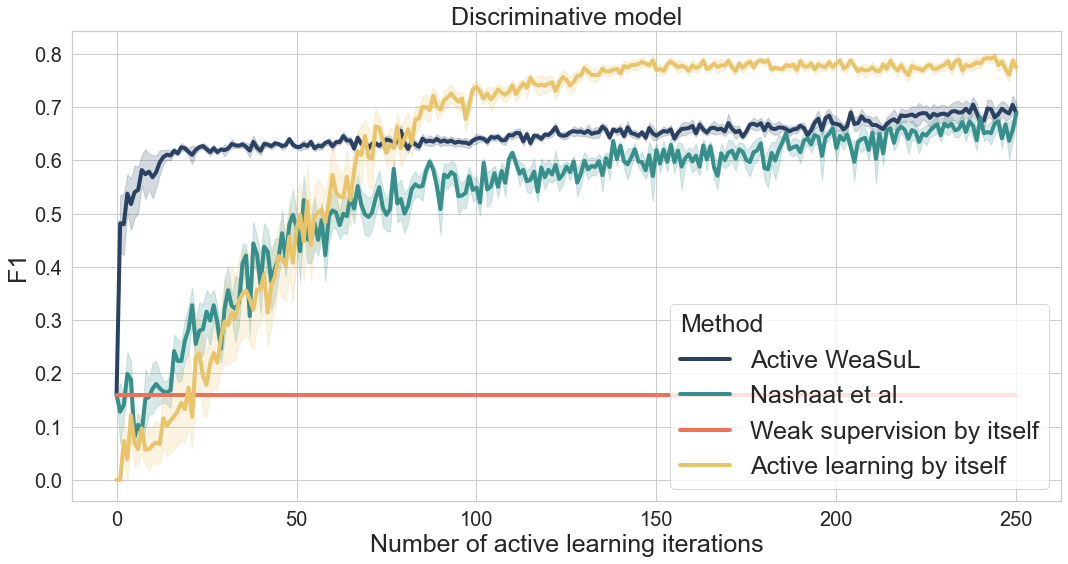

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.lineplot(data=metric_dfs_incl_ws_46[metric_dfs_incl_ws_46["Model"] == "Discriminative"], **plotting_kwargs,
            hue_order=["Active WeaSuL", "Nashaat et al.", "Weak supervision by itself", "Active learning by itself"])

axes.set_title("Discriminative model", fontsize=font_size)

# Legend
handles, labels = axes.get_legend_handles_labels()
[ha.set_linewidth(linewidth) for ha in handles]
leg = axes.legend(handles=handles, labels=labels[0:6], loc="lower right", title="Method",
                     fontsize=legend_size, title_fontsize=legend_size)
leg._legend_box.align = "left"

# Axes
axes.tick_params(axis='both', which='major', labelsize=tick_size)
axes.set_xlabel("Number of active learning iterations", fontsize=font_size)
axes.set_ylabel("F1", fontsize=font_size)

plt.tight_layout()
plt.show()

# Figure 5: Spam Detection

The weak supervision setup for the dataset in this section builds on https://github.com/snorkel-team/snorkel-tutorials/tree/master/spam. We use the first 7 labelling functions and directly import the resulting label matrices. Following related work, we treat the labelling functions as conditionally independent sources.

In [36]:
path_prefix_5 = "../data/spam/"

## Loading and preparing data

In [37]:
label_matrix_train_5 = pickle.load(open(path_prefix_5 + "L_train.pkl", "rb"))
label_matrix_test_5 = pickle.load(open(path_prefix_5 + "L_test.pkl", "rb"))

df_train_5 = pickle.load(open(path_prefix_5 + "X_train.pkl", "rb"))
df_test_5 = pickle.load(open(path_prefix_5 + "X_test.pkl", "rb"))

y_train_5 = pickle.load(open(path_prefix_5 + "Y_train.pkl", "rb"))
y_test_5 = pickle.load(open(path_prefix_5 + "Y_test.pkl", "rb"))

In [38]:
# Drop the data points where all of the labelling functions abstain

indices_keep = label_matrix_train_5.sum(axis=1) != -7
label_matrix_train_5 = label_matrix_train_5[indices_keep]
y_train_5 = y_train_5[indices_keep]

df_train_5 = pd.DataFrame.sparse.from_spmatrix(df_train_5)
df_train_5 = df_train_5.iloc[indices_keep].reset_index()
df_test_5 = pd.DataFrame.sparse.from_spmatrix(df_test_5).reset_index()

## Running experiments

In [39]:
# Update some settings for this dataset

al_it_5 = 100

starting_seed_5 = 34
penalty_strength_5 = 1e6

p_z = 0.58
class_balance_5 = np.array([1 - p_z, p_z])
cliques_5 = [[0],[1],[2],[3],[4],[5],[6]]

discriminative_model_kwargs_5 = dict(input_dim=df_train_5.shape[1],
                                   output_dim=2,
                                   lr=1e-2,
                                   n_epochs=100)

In [40]:
# Collect all experiment parameters

# Common
exp_kwargs_5 = dict(nr_trials=nr_trials,
                  al_it=al_it_5,
                  y_train=y_train_5,
                  batch_size=batch_size_456,
                  y_test=y_test_5)

# Active WeaSuL
aw_exp_kwargs_5 = dict(label_matrix=label_matrix_train_5,
                     cliques=cliques_5,
                     class_balance=class_balance_5,
                     starting_seed=starting_seed_5,
                     penalty_strength=penalty_strength_5,
                     discriminative_model=LogisticRegression(**discriminative_model_kwargs_5),
                     discr_model_frequency=1,
                     train_dataset = CustomTensorDataset(X=torch.Tensor(df_train_5.values), Y=torch.Tensor(y_train_5)),
                     test_dataset = CustomTensorDataset(X=torch.Tensor(df_test_5.values), Y=torch.Tensor(y_test_5)),
                     label_matrix_test=label_matrix_test_5)

### Active WeaSuL

In [41]:
np.random.seed(284)
aw_exp_kwargs_5["seeds"]= np.random.randint(0, 1000, 10)
metrics_maxkl_5, _ = active_weasul_experiment(**exp_kwargs_5, **aw_exp_kwargs_5, query_strategy="maxkl")

### Nashaat et al.

In [42]:
np.random.seed(25)
aw_exp_kwargs_5["seeds"]= np.random.randint(0,1000,10)
metrics_nashaat_5, _ = active_weasul_experiment(**exp_kwargs_5, **aw_exp_kwargs_5, query_strategy="nashaat")

### Active learning

In [43]:
set_seed(76)

# Active learning parameters
al_exp_kwargs_5 = dict(seeds = np.random.randint(0,1000,nr_trials),
                       train_features = torch.Tensor(df_train_5.values),
                       test_features = torch.Tensor(df_test_5.values))

In [44]:
metrics_activelearning_5 = active_learning_experiment(**exp_kwargs_5, **al_exp_kwargs_5, solver="liblinear")

### Process results

In [45]:
# Transform results into dataframes and merge

metric_dfs_5 = pd.concat([process_exp_dict(metrics_maxkl_5, "Active WeaSuL"),
                        process_exp_dict(metrics_nashaat_5, "Nashaat et al."),
                        process_exp_dict(metrics_activelearning_5, "Active learning by itself")]).reset_index(level=0).rename(columns={"level_0": "Run"})

# Add weak supervision baseline
metric_dfs_incl_ws_5 = add_weak_supervision_baseline(metric_dfs_5, al_it_5)

In [46]:
# Filter to plot only F1 metric and test set

metric_dfs_incl_ws_5 = metric_dfs_incl_ws_5[metric_dfs_incl_ws_5["Metric"] == "F1"]
metric_dfs_incl_ws_5 = metric_dfs_incl_ws_5[metric_dfs_incl_ws_5["Set"] == "test"]
metric_dfs_incl_ws_5["Value"] = metric_dfs_incl_ws_5["Value"].fillna(0)

## Figure 5

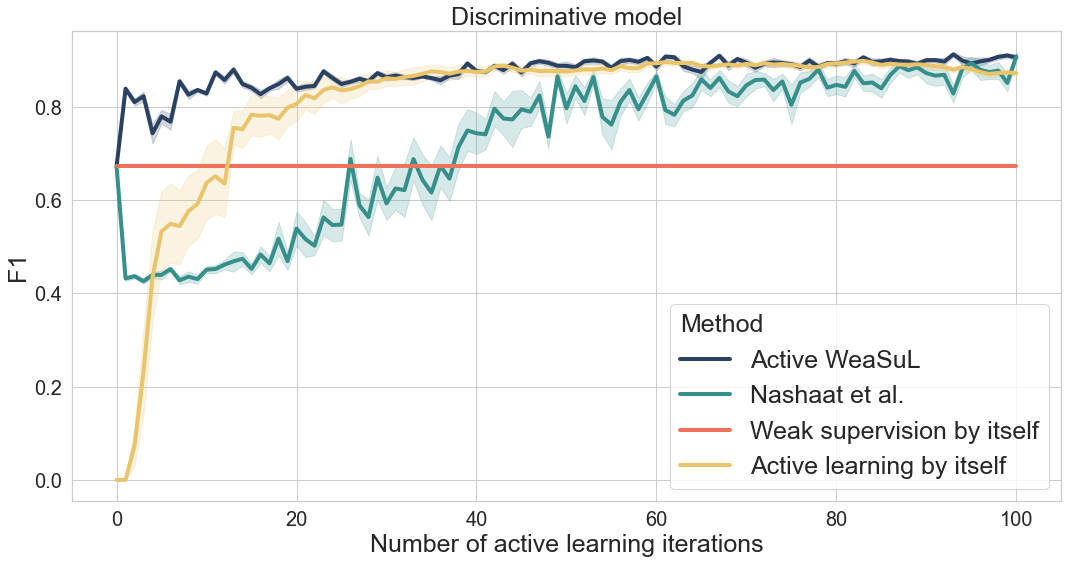

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.lineplot(data=metric_dfs_incl_ws_5[metric_dfs_incl_ws_5["Model"] == "Discriminative"], **plotting_kwargs,
            hue_order=["Active WeaSuL", "Nashaat et al.", "Weak supervision by itself", "Active learning by itself"])

axes.set_title("Discriminative model", fontsize=font_size)

# Legend
handles, labels = axes.get_legend_handles_labels()
[ha.set_linewidth(linewidth) for ha in handles]
leg = axes.legend(handles=handles, labels=labels[0:6], loc="lower right", title="Method",
                     fontsize=legend_size, title_fontsize=legend_size)
leg._legend_box.align = "left"

# Axes
axes.tick_params(axis='both', which='major', labelsize=tick_size)
axes.set_xlabel("Number of active learning iterations", fontsize=font_size)
axes.set_ylabel("F1", fontsize=font_size)

plt.tight_layout()
plt.show()

# Figure 6: Sampling strategies (Visual Relationship Detection)

Now we compare the proposed maxKL sampling strategy to a few other approaches for the visual relationship data set. We compare to margin sampling, which samples based on the distance to the classification boundary, and random sampling.

We also keep track of the entropy of sampled buckets across active learning iterations.

In [48]:
# Switch to 50 iterations to compare sampling approaches

exp_kwargs_46["al_it"] = 50

### Margin sampling

In [49]:
np.random.seed(70)
aw_exp_kwargs_46["seeds"]= np.random.randint(0,1000,nr_trials)
metrics_margin_6, entropies_margin_6 = active_weasul_experiment(**exp_kwargs_46, **aw_exp_kwargs_46, query_strategy="margin")

### Random sampling

In [50]:
np.random.seed(70)
aw_exp_kwargs_46["seeds"]= np.random.randint(0,1000,nr_trials)
metrics_random_6, entropies_random_6 = active_weasul_experiment(**exp_kwargs_46, **aw_exp_kwargs_46, query_strategy="margin", randomness=1)

### Process metrics

In [51]:
# Transform results into dataframes and merge

metric_dfs_6 = pd.concat([process_exp_dict(metrics_maxkl_46, "MaxKL"),
                        process_exp_dict(metrics_margin_6, "Margin"),
                        process_exp_dict(metrics_random_6, "Random")])

In [52]:
# Filter to plot only F1 metric, test set and first 50 iterations

metric_dfs_6 = metric_dfs_6[metric_dfs_6["Metric"].isin(["F1"])]
metric_dfs_6 = metric_dfs_6[metric_dfs_6.Set == "test"]
metric_dfs_6 = metric_dfs_6[metric_dfs_6["Number of labeled points"] < 51]

### Process entropies

In [53]:
# Transform results into dataframes and merge

entropies_df = pd.concat([process_entropies(entropies_maxkl_46, "MaxKL"), 
                          process_entropies(entropies_margin_6, "Margin"), 
                          process_entropies(entropies_random_6, "Random")])

## Figure 6A

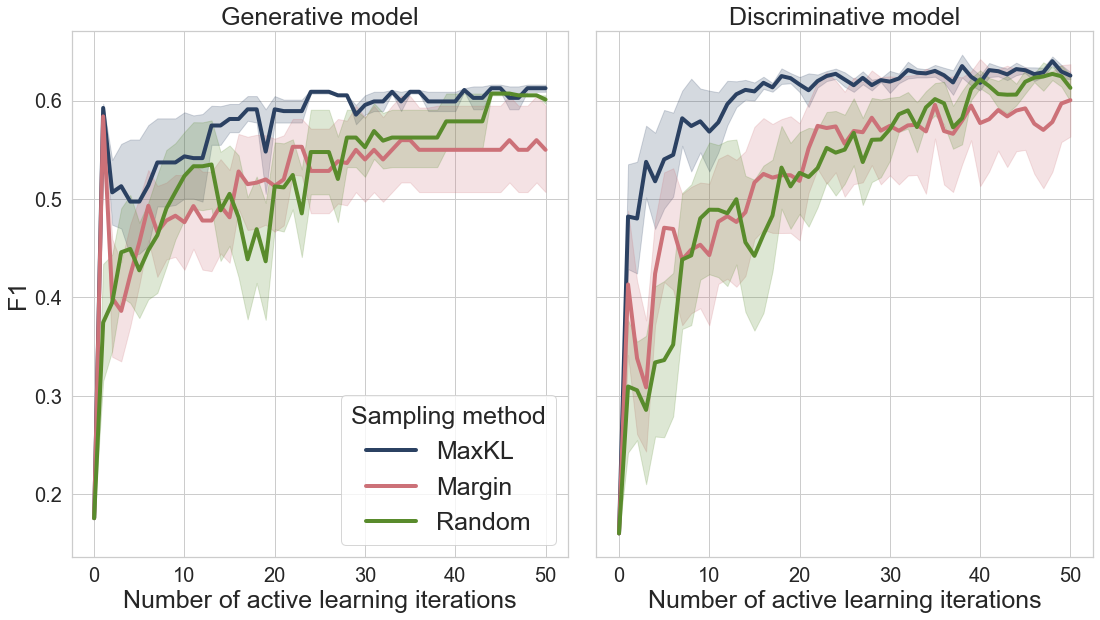

In [54]:
lines = list(metric_dfs_6.Approach.unique())

fig, axes = plt.subplots(1,2, figsize=(15,8), sharey=True)

# Style
colors = ["#2b4162", "#CC7178", "#598B2C", "#e9c46a"][:len(lines)]
sns.set(style="whitegrid", palette=sns.color_palette(colors))
plt.tight_layout()

# Column 1
sns.lineplot(data=metric_dfs_6[metric_dfs_6["Model"] == "Generative"], **plotting_kwargs,
            hue_order=["MaxKL", "Margin", "Random"], ax=axes[0])
axes[0].set_title("Generative model", fontsize=font_size)

# Column 2
sns.lineplot(data=metric_dfs_6[metric_dfs_6["Model"] == "Discriminative"],
             legend=False, **plotting_kwargs, hue_order=["MaxKL", "Margin", "Random"], ax=axes[1])
axes[1].set_title("Discriminative model", fontsize=font_size)

# Legend
handles, labels = axes[0].get_legend_handles_labels()
[ha.set_linewidth(linewidth) for ha in handles]
axes[0].legend(handles=handles, labels=labels, loc="lower right", title="Sampling method", fontsize=legend_size, title_fontsize=legend_size)

# Axes
axes[0].tick_params(axis='both', which='major', labelsize=tick_size)
axes[1].tick_params(axis='both', which='major', labelsize=tick_size)
axes[0].set_xlabel("Number of active learning iterations", fontsize=font_size)
axes[1].set_xlabel("Number of active learning iterations", fontsize=font_size)
axes[0].set_ylabel("F1", fontsize=font_size)

plt.show()

## Figure 6B

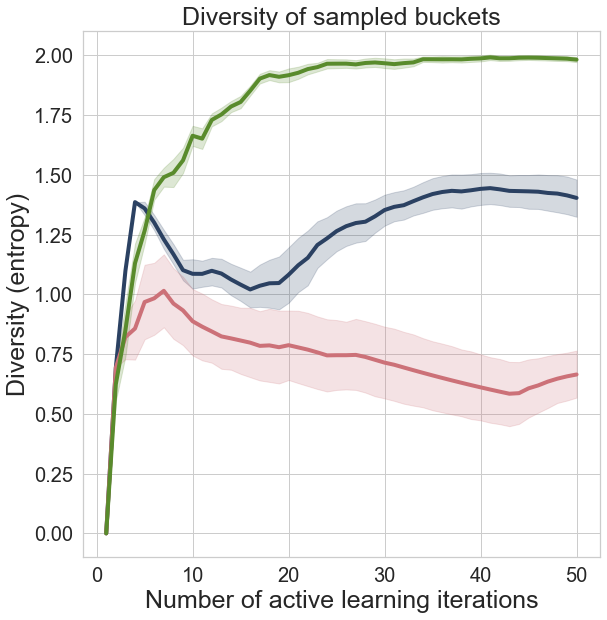

In [55]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plt.tight_layout()

sns.lineplot(data=entropies_df, x="Number of labeled points", y="Entropy", hue="Approach", ci=68, n_boot=n_boot,
                  legend=False, linewidth=linewidth, hue_order=["MaxKL", "Margin","Random"], ax=ax)
ax.set_title("Diversity of sampled buckets", fontsize=font_size)

# Axes
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_xlabel("Number of active learning iterations", fontsize=font_size)
ax.set_ylabel("Diversity (entropy)", fontsize=font_size)

plt.show()